## Directory Managing

In [6]:
train_csv_path = '/content/updated_train_data500images_corrected.csv'
val_csv_path = ''
test_csv_path = ''


lexicon_file_path = '/content/lexicon.txt'

store_knn_classifier = '/content/knn_phoc_classifier1.pkl'

In [15]:
# Library loading
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms

from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

!pip install wandb
import wandb
import editdistance

In [16]:
# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Wandb Functions

In [17]:
# Set of functions to log different aspects of our model's execution on wandb

def train_log(loss, total_example_ct):
    wandb.log({"loss": loss}, step=total_example_ct)
    print(f"Loss after {str(total_example_ct).zfill(5)} examples: {loss:.3f}")

def train_test_log(loss_test, loss_train, accuracy_test, accuracy_train, edit_test, edit_train, epoch):
    wandb.log({"Epoch": epoch,
               "Train loss": loss_train, "Test loss": loss_test,
               "Train accuracy": accuracy_train, "Test accuracy": accuracy_test,
               "Train edit": edit_train, "Test edit": edit_test,
               })
    print(f"Train Loss: {loss_train:.3f}\nTest Loss: {loss_test:.3f}")


# Set of functions to log the images into wandb
def log_images(images, predicted_labels, text_labels, epoch, mode):
    t = transforms.Compose([transforms.Normalize(0, 1/0.1),transforms.Normalize(-0.5, 1)])
    t_images = t(images)
    images_with_labels = draw_images(t_images, text_labels, predicted_labels)
    wandb.log({f"Epoch{epoch}-{mode}": [wandb.Image(im) for im in images_with_labels]})

def draw_images(images, text_labels, predicted_labels):
    transform = T.ToPILImage()
    images = [draw_one_image(transform(im), t_lab, p_lab) for im, t_lab, p_lab in zip(images, text_labels, predicted_labels)]
    return images

def draw_one_image(image, text_label, predicted_label):
    image = image.convert("RGB")
    draw = ImageDraw.Draw(image)
    if text_label == predicted_label:
        color = "green"
    else:
        color = "red"
    text = text_label + "\n" + predicted_label

    # Use the default font
    font = ImageFont.load_default()

    draw.text((0, 0), text, font=font, fill=color)
    return image

# Log the learning rate
def lr_log(lr, epoch):
    wandb.log({"learning-rate": lr}, step=epoch)

## Data Visualization

In [18]:
# Load the csv files: they contain image_path, label
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)
val_data = pd.read_csv(val_csv_path)

In [19]:
list_of_words =  train_data['label'].tolist()

In [20]:
# Checking if labels have been loaded correctly
if 'TREASONOUS' in list_of_words:
    print("Works")

Works


(31, 149, 3)
pegged


(31, 104, 3)


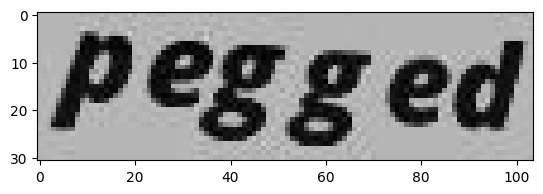

In [21]:
from google.colab.patches import cv2_imshow
# Checking the images and their dimentions
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/144_EMIGRANTS_25365.jpg')

cv2_imshow(img)
plt.imshow(img)
print(img.shape)


img = cv2.imread(train_data['image_path'][2])
print(train_data['label'][2])

cv2_imshow(img)
plt.imshow(img)
print(img.shape)


## PHOC and KNN

In [22]:
def build_phoc(words, phoc_unigrams, unigram_levels,
               bigram_levels=None, phoc_bigrams=None,
               split_character=None):
    '''
    Calculate Pyramidal Histogram of Characters (PHOC) descriptor (see Almazan 2014).
    Args:
        word (str): word to calculate descriptor for
        phoc_unigrams (str): string of all unigrams to use in the PHOC
        unigram_levels (list of int): the levels for the unigrams in PHOC
        phoc_bigrams (list of str): list of bigrams to be used in the PHOC
        phoc_bigram_levls (list of int): the levels of the bigrams in the PHOC
        split_character (str): special character to split the word strings into characters
        on_unknown_unigram (str): What to do if a unigram appearing in a word
            is not among the supplied phoc_unigrams. Possible: 'warn', 'error'
    Returns:
        the PHOC for the given word
    '''
    # prepare output matrix
    phoc_size = len(phoc_unigrams) * np.sum(unigram_levels)
    if phoc_bigrams is not None:
        phoc_size += len(phoc_bigrams) * np.sum(bigram_levels)
    phocs = np.zeros((len(words), phoc_size))

    # prepare some lambda functions
    occupancy = lambda k, n: [float(k) / n, float(k + 1) / n]
    overlap = lambda a, b: [max(a[0], b[0]), min(a[1], b[1])]
    size = lambda region: region[1] - region[0]

    # map from character to alphabet position
    char_indices = {d: i for i, d in enumerate(phoc_unigrams)}

    # iterate through all the words
    for word_index, word in enumerate(words):
        """if '0' in word or '1' in word or '2' in word or '3' in word or '4' in word or '5' in word or '6' in word or '7' in word or '7' in word or '8' in word or '9' in word:
            continue"""
        if split_character is not None:
            word = word.split(split_character)
        n = len(word)
        for index, char in enumerate(word):
            char_occ = occupancy(index, n)
            char_index = char_indices[char]

            for level in unigram_levels:
                for region in range(level):
                    region_occ = occupancy(region, level)
                    if size(overlap(char_occ, region_occ)) / size(char_occ) >= 0.5:
                        feat_vec_index = sum([l for l in unigram_levels if l < level]) * len(
                            phoc_unigrams) + region * len(phoc_unigrams) + char_index
                        phocs[word_index, feat_vec_index] = 1

        # add bigrams
        if phoc_bigrams is not None:
            ngram_features = np.zeros(len(phoc_bigrams) * np.sum(bigram_levels))
            ngram_occupancy = lambda k, n: [float(k) / n, float(k + 2) / n]

            for i in range(n - 1):
                ngram = word[i:i + 2]
                phoc_dict = {k: v for v, k in enumerate(phoc_bigrams)}
                if phoc_dict.get(ngram, 666) == 666:
                    continue
                occ = ngram_occupancy(i, n)

                for level in bigram_levels:
                    for region in range(level):
                        region_occ = occupancy(region, level)
                        overlap_size = size(overlap(occ, region_occ)) / size(occ)
                        if overlap_size >= 0.5:
                            ngram_features[region * len(phoc_bigrams) + phoc_dict[ngram]] = 1
            phocs[word_index, -ngram_features.shape[0]:] = ngram_features

    return phocs

# Computes the phoc vector for a given str
def phoc(raw_word):
    if isinstance(raw_word, list):
        word = [w.lower() for w in raw_word]
    else:
        word = [raw_word.lower()]
    phoc_unigrams = '0123456789abcdefghijklmnopqrstuvwxyz'
    unigram_levels = [2, 3, 4, 5]
    bigram_levels = [2]
    phoc_bigrams = ['th', 'he', 'in', 'er', 'an',
                    're', 'on', 'at', 'en', 'nd',
                    'ti', 'es', 'or', 'te', 'of',
                    'ed', 'is', 'it', 'al', 'ar',
                    'st', 'to', 'nt', 'ng', 'se',
                    'ha', 'as', 'ou', 'io', 'le',
                    've', 'co', 'me', 'de', 'hi',
                    'ri', 'ro', 'ic', 'ne', 'ea',
                    'ra', 'ce', 'li', 'ch', 'll',
                    'be', 'ma', 'si', 'om', 'ur']

    qry_phocs = build_phoc(words=word, phoc_unigrams=phoc_unigrams, unigram_levels=unigram_levels,
                           bigram_levels=bigram_levels, phoc_bigrams=phoc_bigrams)
    return torch.tensor(qry_phocs[0])

In [24]:
# Read words from the .txt file
with open('/content/lexicon.txt', 'r') as file:
    words = [line.strip() for line in file]

# Compute PHOC descriptors
phoc_descriptors = []
for word in words:
    phoc_descriptors.append(phoc(word).numpy())

phoc_descriptors = np.array(phoc_descriptors)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(phoc_descriptors, words)

# Save the trained KNN classifier to a file
with open('knn_phoc_classifier1.pkl', 'wb') as knnPickle:
    pickle.dump(knn, knnPickle)

print("KNN classifier trained and saved successfully.")

KNN classifier trained and saved successfully.


In [25]:
# Checking that the shape is 604
print(phoc_descriptors[6788].shape)

(604,)


## Dataset

In [26]:
# Creating a Custom Dataset on which to load the image & its labels (both in str and phoc vector form)

class CustomDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data_frame = pd.read_csv(csv_file_path)
        self.transform = transform
        self.label_to_index = {label: idx for idx, label in enumerate(self.data_frame['label'].unique())}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        str_label = self.data_frame.iloc[idx, 1].lower()
        target = phoc(str_label)

        if self.transform:
            image = self.transform(image)

        return image, target, str_label

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Model

In [27]:
class SPP(nn.Module):
    def __init__(self, levels=3, pool_type='max_pool'):
        super(SPP, self).__init__()

        # Check if the pool_type is valid
        if pool_type not in ['max_pool', 'avg_pool', 'max_avg_pool']:
            raise ValueError('Unknown pool_type. Must be either \'max_pool\', \'avg_pool\' or both')

        self.pooling_output_size = sum([4 ** level for level in range(levels)]) * 512
        self.levels = levels
        self.pool_type = pool_type

    def forward(self, input_x):
        out = self._spatial_pyramid_pooling(input_x, self.levels)
        return out

    def _pyramid_pooling(self, input_x, output_sizes):
        pyramid_level_tensors = []

        # Support for various types of pooling
        for tsize in output_sizes:
            if self.pool_type == 'max_pool':
                pyramid_level_tensor = F.adaptive_max_pool2d(input_x, tsize)
                pyramid_level_tensor = pyramid_level_tensor.view(input_x.size(0), -1)
            if self.pool_type == 'avg_pool':
                pyramid_level_tensor = F.adaptive_avg_pool2d(input_x, tsize)
                pyramid_level_tensor = pyramid_level_tensor.view(input_x.size(0), -1)
            if self.pool_type == 'max_avg_pool':
                pyramid_level_tensor_max = F.adaptive_max_pool2d(input_x, tsize)
                pyramid_level_tensor_max = pyramid_level_tensor_max.view(input_x.size(0), -1)
                pyramid_level_tensor_avg = F.adaptive_avg_pool2d(input_x, tsize)
                pyramid_level_tensor_avg = pyramid_level_tensor_avg.view(input_x.size(0), -1)
                pyramid_level_tensor = torch.cat([pyramid_level_tensor_max, pyramid_level_tensor_avg], dim=1)

            pyramid_level_tensors.append(pyramid_level_tensor)

        return torch.cat(pyramid_level_tensors, dim=1)

     # Define the spatial pyramid pooling function
    def _spatial_pyramid_pooling(self, input_x, levels):
        output_sizes = [(int(2 ** level), int(2 ** level)) for level in range(levels)]
        return self._pyramid_pooling(input_x, output_sizes)


# Define the PHOCNet model from the GH Repo
class PHOCNet(nn.Module):
    def __init__(self, n_out, input_channels=3, pooling_levels=3, pool_type='max_pool'):
        super(PHOCNet, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.pooling_layer_fn = SPP(levels=pooling_levels, pool_type=pool_type)
        pooling_output_size = self.pooling_layer_fn.pooling_output_size

        self.fc1 = nn.Linear(pooling_output_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_out)

    def forward(self, x):
        out = self.conv_block1(x)
        out = F.max_pool2d(out, kernel_size=2, stride=2, padding=0)
        out = self.conv_block2(out)
        out = F.max_pool2d(out, kernel_size=2, stride=2, padding=0)
        out = self.conv_block3(out)
        out = self.conv_block4(out)

        out = self.pooling_layer_fn(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.fc2(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.fc3(out)

        return out

    # Initialize weights with normal distribution
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

## Train and Test Loop

In [28]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, config, device="cuda"):
    wandb.watch(model, criterion, log="all", log_freq=10) # Watch the model with wandb

    # Initialize counters
    example_ct = 0
    batch_ct = 0
    model_phoc = load_model() # Load the KNN Model

    # Iterate through epochs
    for epoch in tqdm(range(int(config['epochs']))):
        model.train()
        train_loss = 0
        # Iterate through batches of training data and train on said batch
        for _, (images, phoc_labels, _) in enumerate(train_loader):
            loss = train_batch(images, phoc_labels, model, optimizer, criterion, device)
            train_loss += loss.item()
            example_ct += len(images)
            batch_ct += 1

            # Log training progress every 25 batches
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss.item(), example_ct)

        loss_test = test(model, test_loader, train_loader, epoch, criterion, model_phoc, device)

        # Adjust the learning rate based on the test loss
        scheduler.step(loss_test)
        print(scheduler._last_lr)
        os.makedirs(config['save_model'], exist_ok=True)
        torch.save(model.state_dict(), os.path.join(config['save_model'], f"PHOCNET{epoch}.pt"))
    return model

# Train on a single batch
def train_batch(images, labels, model, optimizer, criterion, device="cuda"):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs.float(), labels.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

# Load the KNN model from a file
def load_model():
    return pickle.load(open(store_knn_classifier, 'rb'))


# Predict labels using the PHOC model
def predict_with_PHOC(phocs, model):
    result = model.predict(phocs)
    return result

def test(model, test_loader, train_loader, epoch, criterion, model_phoc, device="cuda", save=True):
    model.eval()
    with torch.no_grad():
      # Initialize metrics
        loss_test = 0
        loss_train = 0
        correct_test = 0
        correct_train = 0
        edit_test = 0
        edit_train = 0
        test_count = 0
        train_count = 0

        # Evaluate on test data
        for i, (images, phoc_labels, text_labels) in enumerate(test_loader):
            images, phoc_labels = images.to(device), phoc_labels.to(device)
            test_count += len(images)
            outputs = model(images)
            loss_test += criterion(outputs, phoc_labels.float())
            predicted_labels = predict_with_PHOC(torch.sigmoid(outputs).cpu().numpy(), model_phoc)
            correct_test += (predicted_labels == text_labels).sum().item()
            edit_test += sum([editdistance.eval(p, t) for p, t in zip(predicted_labels, text_labels)])
            if i == 0:
                log_images(images, predicted_labels, text_labels[:5], epoch, "Test")

        # Evaluate on a subset of training data
        for i, (images, phoc_labels, text_labels) in enumerate(train_loader):
            images, phoc_labels = images.to(device), phoc_labels.to(device)
            train_count += len(images)
            outputs = model(images)
            loss_train += criterion(outputs, phoc_labels.float())
            predicted_labels = predict_with_PHOC(torch.sigmoid(outputs).cpu().numpy(), model_phoc)
            correct_train += (predicted_labels == text_labels).sum().item()
            edit_train += sum([editdistance.eval(p, t) for p, t in zip(predicted_labels, text_labels)])
            if i == 0:
                log_images(images, predicted_labels, text_labels[:5], epoch, "Train")
            if i == 150:
                break

        # Calculate average loss and accuracy
        loss_test = loss_test / len(test_loader)
        loss_train = loss_train / (i + 1)
        accuracy_test = correct_test / test_count
        accuracy_train = correct_train / train_count
        edit_test = edit_test / test_count
        edit_train = edit_train / train_count

        train_test_log(loss_test, loss_train, accuracy_test, accuracy_train, edit_test, edit_train, epoch) # Log training and testing metrics

    return loss_test

## Model Pipeline

In [29]:
# Function to create and initialize the model, and create data loaders
def make(config, device="cuda"):
    # Create data loaders
    dataset = CustomDataset(config['train_dir'], transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Make the model
    model = PHOCNet(n_out=604, input_channels=3).to(device)
    model.apply(init_weights_model)

    # Define the loss criterion
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')

    # Define the optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    scheduler = StepLR(optimizer, step_size=2, gamma=0.3)

    return model, train_loader, test_loader, criterion, optimizer, scheduler

# Initialize weights for the model layers
def init_weights_model(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Set parameters to require gradient computation for fine-tuning
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Function to run the config and training of the model
def model_pipeline(cfg: dict) -> None:
    # Initialize a new wandb run
    with wandb.init(project="phocnet-project", config=cfg):
        config = wandb.config

        model, train_loader, test_loader, criterion, optimizer, scheduler = make(config, device)
        model = train(model, train_loader, test_loader, criterion, optimizer, scheduler, config, device)

        return model

## Execution

In [31]:
if __name__ == "__main__":
    wandb.login()

    config = dict(
        train_dir='/content/updated_train_data500images_corrected.csv',
        test_dir='/content/updated_train_data500images_corrected.csv',
        epochs=8,
        batch_size=8,
        learning_rate=0.01,
        save_model='./models'
    )

    model = model_pipeline(config)

  0%|          | 0/8 [00:00<?, ?it/s]

Loss after 00192 examples: 0.414
Train Loss: 0.238
Test Loss: 0.241
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 12%|█▎        | 1/8 [00:59<06:58, 59.77s/it]

Loss after 00388 examples: 0.253
Loss after 00588 examples: 0.253
Train Loss: 0.207
Test Loss: 0.210
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 25%|██▌       | 2/8 [01:46<05:10, 51.81s/it]

Loss after 00784 examples: 0.224
Train Loss: 0.186
Test Loss: 0.191
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 38%|███▊      | 3/8 [02:38<04:21, 52.28s/it]

Loss after 00980 examples: 0.210
Loss after 01180 examples: 0.207
Train Loss: 0.182
Test Loss: 0.186
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 50%|█████     | 4/8 [03:25<03:19, 49.91s/it]

Loss after 01376 examples: 0.209
Train Loss: 0.180
Test Loss: 0.184
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 62%|██████▎   | 5/8 [04:12<02:26, 48.97s/it]

Loss after 01572 examples: 0.241
Loss after 01772 examples: 0.216
Train Loss: 0.179
Test Loss: 0.183
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 75%|███████▌  | 6/8 [04:57<01:35, 47.65s/it]

Loss after 01968 examples: 0.192
Train Loss: 0.183
Test Loss: 0.188
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 88%|████████▊ | 7/8 [05:42<00:46, 46.91s/it]

Loss after 02164 examples: 0.194
Loss after 02364 examples: 0.184
Train Loss: 0.181
Test Loss: 0.184
[tensor(0.0100, device='cuda:0')]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 8/8 [06:29<00:00, 48.70s/it]


Epoch,▁▂▃▄▅▆▇█
Test accuracy,▁▁▁▁▁▁▁▁
Test edit,█▁▁▁▁▁▁▁
Test loss,█▄▂▁▁▁▂▁
Train accuracy,▁▁▁▁▁▁▁▁
Train edit,█▂▁▁▁▁▁▁
Train loss,█▄▂▁▁▁▂▁
loss,█▃▃▂▂▂▂▃▂▁▁▁
Epoch,7
Test accuracy,0.0
Test edit,7.64103
